In [1]:
import torch
import torch.optim as optim
import numpy as np
import scanpy as sc
import scvelo as scv
import sys, os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from model import NETWORK  # Ensure that model.py is saved in the same directory
from dataloaders import * # Ensure that dataloaders.py is saved in the same directory
from utils import *
from sklearn.manifold import Isomap
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra
import gc
import pandas as pd
import seaborn as sns

In [2]:
# Setup configuration
latent_dim = 64  # Latent dimension size, can be adjusted
hidden_dim = 512  # Hidden dimension size for the encoder and decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

n_components = 100
n_knn_search = 10
dataset_name = "gastrulation_erythroid"
cell_type_key = "celltype"
model_name = "VeloFormer"

num_genes = 2000
nhead = 1 #original: 1
embedding_dim = 128*nhead# original: 128
num_encoder_layers = 1 #original: 1
num_bins = 50
batch_size = 128  # Batch size for training
epochs = 10  # Number of epochs for training
learning_rate = 1e-4  # Learning rate for the optimizer
lambda1 = 1e-1  # Weight for heuristic loss
lambda2 = 1 # Weight for discrepancy loss
K = 11  # Number of neighbors for heuristic loss

# Load data
adata = sc.read_h5ad("gastrulation_processed.h5ad")


# Initialize model, optimizer, and loss function
model = NETWORK(input_dim=adata.shape[1]*2, latent_dim=latent_dim, 
                hidden_dim=hidden_dim, emb_dim = embedding_dim,
                nhead=nhead, num_encoder_layers=num_encoder_layers,
                num_genes=num_genes, num_bins=num_bins).to(device)
                
model.load_state_dict(torch.load('model_10epochs.pth'))

# Ensure to call model.eval() if you're loading the model for inference to set the dropout and batch normalization layers to evaluation mode
model.eval()


NETWORK(
  (embeddings): Embedding(4000, 128)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=

In [3]:
adata.obs["sample"] = pd.Categorical(adata.obs["sample"])
cell_types_to_select = ["Blood progenitors 1", "Blood progenitors 2", "Erythroid1", "Erythroid2", "Erythroid3"]  # Replace with your desired cell types
adata_sample = adata[adata.obs["celltype"].isin(cell_types_to_select)].copy()
adata_sample = adata_sample[adata_sample.obs["sample"] == 16,:].copy()
adata_sample.shape

(1210, 2000)

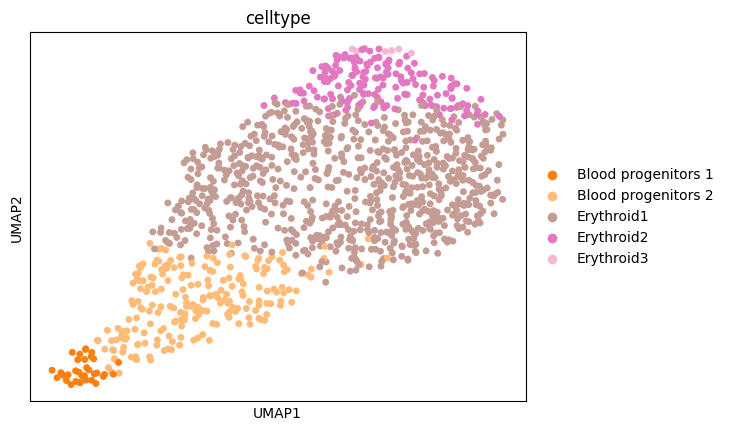

In [4]:
sc.pp.neighbors(adata_sample)
sc.tl.umap(adata_sample)
sc.pl.umap(adata_sample, color="celltype")

In [5]:
blood_progenitors_adata = adata_sample[adata_sample.obs["celltype"] == "Blood progenitors 1"].copy()

In [6]:
def compute_bin_ranges(data, num_bins):
    """
    Compute bin edges for each gene based on expression values.
    """
    max_values = np.max(data, axis=0)
    bin_ranges = max_values / num_bins
    return bin_ranges  # Shape: (num_genes,)

# Assuming adata.layers["Mu"] and adata.layers["Ms"] are available
combined_expression = np.concatenate([adata.layers["Mu"], adata.layers["Ms"]], axis=1)
bin_ranges = compute_bin_ranges(combined_expression, num_bins=50)

# Save bin_ranges for later use
blood_progenitors_adata.uns["bin_ranges"] = bin_ranges

In [7]:
def get_velocity(blood_progenitors_adata):
    dataloader = setup_dataloaders_for_subset(blood_progenitors_adata, bin_ranges, batch_size)
    model.eval()
    with torch.no_grad():
        for batch_idx, (tokens, data, batch_indices) in enumerate(dataloader):
            print(f"Batch {batch_idx+1}/{len(dataloader)}")
            tokens = tokens.to(device)
            data = data.to(device)
            out_dic = model(tokens, data)

            # Store results and convert to numpy inside the loop to reduce peak memory usage
            v_u = out_dic["v_u"].detach().cpu().numpy()
            v_s = out_dic["v_s"].detach().cpu().numpy()
            
    return v_u, v_s

In [8]:
dt = .01

u0 = blood_progenitors_adata.layers["Mu"] 
s0 = blood_progenitors_adata.layers["Ms"] 

n_steps = 100
blood_progenitors_adata.uns["pred_u"] = np.zeros((blood_progenitors_adata.shape[0], blood_progenitors_adata.shape[1], n_steps+1))
blood_progenitors_adata.uns["pred_s"] = np.zeros((blood_progenitors_adata.shape[0], blood_progenitors_adata.shape[1], n_steps+1))
blood_progenitors_adata.uns["v_u"] = np.zeros((blood_progenitors_adata.shape[0], blood_progenitors_adata.shape[1], n_steps+1))
blood_progenitors_adata.uns["v_s"] = np.zeros((blood_progenitors_adata.shape[0], blood_progenitors_adata.shape[1], n_steps+1))

u_t = u0.copy()
s_t = s0.copy()

blood_progenitors_adata.uns["pred_u"][:,:,0] = u0
blood_progenitors_adata.uns["pred_s"][:,:,0] = s0

In [9]:
for t in range(n_steps):
   print(t)
   blood_progenitors_adata.layers["pred_u"] = u_t
   blood_progenitors_adata.layers["pred_s"] = s_t

   v_u, v_s = get_velocity(blood_progenitors_adata)

   v_u *=-1
   v_s *=-1

   blood_progenitors_adata.uns["v_u"][:,:,t] = v_u
   blood_progenitors_adata.uns["v_s"][:,:,t] = v_s

   # Compute L2 norms for each velocity vector
   norm_v_u = np.linalg.norm(v_u, axis=0, keepdims=True)
   norm_v_s = np.linalg.norm(v_s, axis=0, keepdims=True)

   # Avoid division by zero by setting norms of zero to one
   norm_v_u[norm_v_u == 0] = 1
   norm_v_s[norm_v_s == 0] = 1

   # Normalize each vector by its magnitude
   v_u_normalized = v_u / norm_v_u
   v_s_normalized = v_s / norm_v_s

      
   u_t += v_u_normalized*dt
   s_t += v_s_normalized*dt


   blood_progenitors_adata.uns["pred_u"][:,:,t+1] = u_t
   blood_progenitors_adata.uns["pred_s"][:,:,t+1] = s_t


blood_progenitors_adata.layers["pred_u"] = u_t
blood_progenitors_adata.layers["pred_s"] = s_t

v_u, v_s = get_velocity(blood_progenitors_adata)

v_u *=-1
v_s *=-1

blood_progenitors_adata.uns["v_u"][:,:,t] = v_u
blood_progenitors_adata.uns["v_s"][:,:,t] = v_s

# Compute L2 norms for each velocity vector
norm_v_u = np.linalg.norm(v_u, axis=0, keepdims=True)
norm_v_s = np.linalg.norm(v_s, axis=0, keepdims=True)

# Avoid division by zero by setting norms of zero to one
norm_v_u[norm_v_u == 0] = 1
norm_v_s[norm_v_s == 0] = 1

# Normalize each vector by its magnitude
v_u_normalized = v_u / norm_v_u
v_s_normalized = v_s / norm_v_s

u_t += v_u_normalized*dt
s_t += v_s_normalized*dt

blood_progenitors_adata.uns["pred_u"][:,:,t+1] = u_t
blood_progenitors_adata.uns["pred_s"][:,:,t+1] = s_t


0
Batch 1/1
1
Batch 1/1
2
Batch 1/1
3
Batch 1/1
4
Batch 1/1
5
Batch 1/1
6
Batch 1/1
7
Batch 1/1
8
Batch 1/1
9
Batch 1/1
10
Batch 1/1
11
Batch 1/1
12
Batch 1/1
13
Batch 1/1
14
Batch 1/1
15
Batch 1/1
16
Batch 1/1
17
Batch 1/1
18
Batch 1/1
19
Batch 1/1
20
Batch 1/1
21
Batch 1/1
22
Batch 1/1
23
Batch 1/1
24
Batch 1/1
25
Batch 1/1
26
Batch 1/1
27
Batch 1/1
28
Batch 1/1
29
Batch 1/1
30
Batch 1/1
31
Batch 1/1
32
Batch 1/1
33
Batch 1/1
34
Batch 1/1
35
Batch 1/1
36
Batch 1/1
37
Batch 1/1
38
Batch 1/1
39
Batch 1/1
40
Batch 1/1
41
Batch 1/1
42
Batch 1/1
43
Batch 1/1
44
Batch 1/1
45
Batch 1/1
46
Batch 1/1
47
Batch 1/1
48
Batch 1/1
49
Batch 1/1
50
Batch 1/1
51
Batch 1/1
52
Batch 1/1
53
Batch 1/1
54
Batch 1/1
55
Batch 1/1
56
Batch 1/1
57
Batch 1/1
58
Batch 1/1
59
Batch 1/1
60
Batch 1/1
61
Batch 1/1
62
Batch 1/1
63
Batch 1/1
64
Batch 1/1
65
Batch 1/1
66
Batch 1/1
67
Batch 1/1
68
Batch 1/1
69
Batch 1/1
70
Batch 1/1
71
Batch 1/1
72
Batch 1/1
73
Batch 1/1
74
Batch 1/1
75
Batch 1/1
76
Batch 1/1
77
Batch 

         Falling back to preprocessing with `sc.pp.pca` and default params.


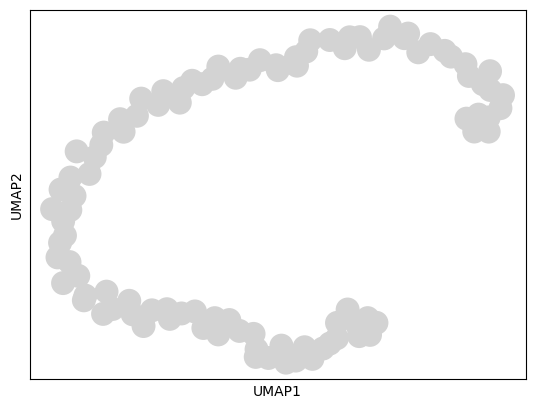

computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


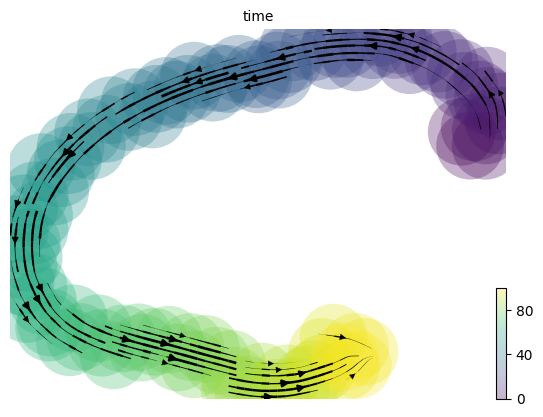

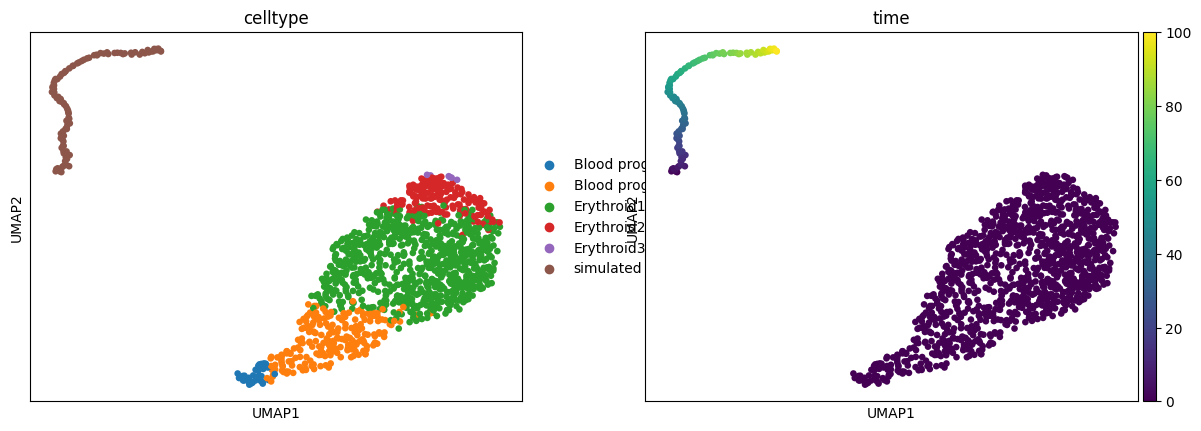

[0.         0.6710569  0.00523714 ... 0.40734217 0.37077203 1.5460454 ]


In [10]:
for i in range(1):
    # Expand the initial condition matrix along the last dimension
    """initial_condition_expanded = np.expand_dims(s0, axis=-1)  # Shape: (34, 2000, 1)
    initial_condition_expanded_v = np.expand_dims(blood_progenitors_adata.uns["v_s"], axis=-1)
    combined_data = np.concatenate([initial_condition_expanded, blood_progenitors_adata.uns["pred_s"]], axis=-1)  # Shape: (34, 2000, 101)
    combined_data_v = np.concatenate([initial_condition_expanded, blood_progenitors_adata.uns["v_s"]], axis=-1)  # Shape: (34, 2000, 101)"""

    
    trajectory = sc.AnnData(X=blood_progenitors_adata.uns["pred_s"][i].T)
    trajectory.layers["velocity"] = blood_progenitors_adata.uns["v_s"][i].T
    trajectory.layers["spliced"] = trajectory.X
    trajectory.var_names = blood_progenitors_adata.var_names
    trajectory.obs["time"] = np.array(trajectory.obs_names.values, dtype="int")
    assert((blood_progenitors_adata.uns["pred_s"][0].T[0] - trajectory.X[0]).sum() == 0)
    assert((blood_progenitors_adata.layers["Ms"][0] - trajectory.X[0]).sum() == 0)
    sc.pp.neighbors(trajectory)
    sc.tl.umap(trajectory)
    sc.pl.umap(trajectory)
    scv.tl.velocity_graph(trajectory)
    scv.pl.velocity_embedding_stream(trajectory, color="time")
    trajectory.obs["celltype"] = "simulated"
    adata_concat = sc.concat([adata_sample, trajectory], axis=0)
    adata_concat.obs["time"] = 0
    adata_concat.obs["time"].iloc[adata_sample.shape[0]:,] = np.array(trajectory.obs_names.values, dtype="int")
    sc.pp.neighbors(adata_concat)
    sc.tl.umap(adata_concat)
    sc.pl.umap(adata_concat, color=["celltype","time"])
    print(blood_progenitors_adata.layers["Ms"][0])

In [11]:
adata_sample.obs["time"] = -1 * Isomap(n_components=1).fit_transform(adata_sample.layers["Ms"])


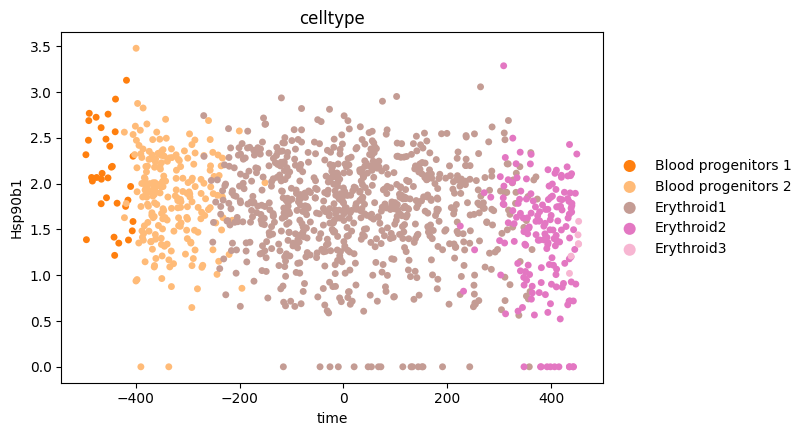

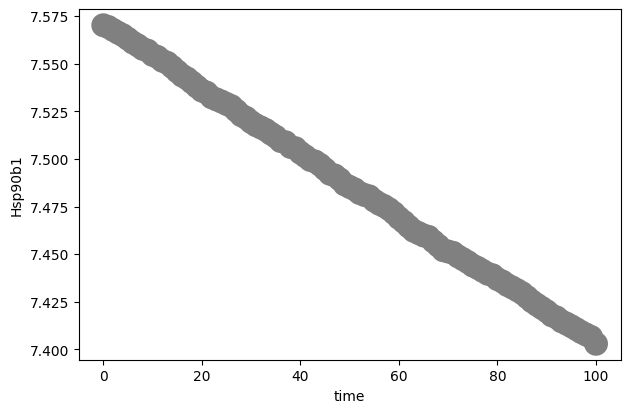

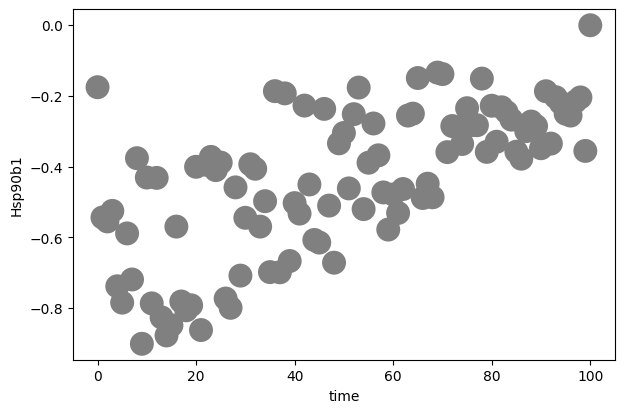

In [17]:
gene_name = "Hsp90b1"
#sc.pl.violin(adata_sample, keys=gene_name, groupby="celltype")
sc.pl.scatter(adata_sample, x="time", y=gene_name, color="celltype")
sc.pl.scatter(trajectory, x="time", y=gene_name)
sc.pl.scatter(trajectory, x="time", y=gene_name, layers="velocity")

In [13]:
#blood_progenitors_adata.uns["pred_s"].reshape((34*101, 2000)).shape

In [14]:
"""trajectory = sc.AnnData(X=blood_progenitors_adata.uns["pred_s"].reshape((34*101, 2000)))
trajectory.layers["velocity"] = blood_progenitors_adata.uns["v_s"].reshape((34*101, 2000))
trajectory.layers["spliced"] = trajectory.X
trajectory.var_names = blood_progenitors_adata.var_names
#trajectory.obs["time"] = np.array(trajectory.obs_names.values, dtype="int")
#assert((blood_progenitors_adata.uns["pred_s"][0].T[0] - trajectory.X[0]).sum() == 0)
#assert((blood_progenitors_adata.layers["Ms"][0] - trajectory.X[0]).sum() == 0)
sc.pp.neighbors(trajectory)
sc.tl.umap(trajectory)
sc.pl.umap(trajectory)
scv.tl.velocity_graph(trajectory)
scv.pl.velocity_embedding_stream(trajectory)
trajectory.obs["celltype"] = "simulated"
adata_concat = sc.concat([adata_sample, trajectory], axis=0)
#adata_concat.obs["time"] = 0
#adata_concat.obs["time"].iloc[adata_sample.shape[0]:,] = np.array(trajectory.obs_names.values, dtype="int")
sc.pp.neighbors(adata_concat)
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=["celltype"])
"""

'trajectory = sc.AnnData(X=blood_progenitors_adata.uns["pred_s"].reshape((34*101, 2000)))\ntrajectory.layers["velocity"] = blood_progenitors_adata.uns["v_s"].reshape((34*101, 2000))\ntrajectory.layers["spliced"] = trajectory.X\ntrajectory.var_names = blood_progenitors_adata.var_names\n#trajectory.obs["time"] = np.array(trajectory.obs_names.values, dtype="int")\n#assert((blood_progenitors_adata.uns["pred_s"][0].T[0] - trajectory.X[0]).sum() == 0)\n#assert((blood_progenitors_adata.layers["Ms"][0] - trajectory.X[0]).sum() == 0)\nsc.pp.neighbors(trajectory)\nsc.tl.umap(trajectory)\nsc.pl.umap(trajectory)\nscv.tl.velocity_graph(trajectory)\nscv.pl.velocity_embedding_stream(trajectory)\ntrajectory.obs["celltype"] = "simulated"\nadata_concat = sc.concat([adata_sample, trajectory], axis=0)\n#adata_concat.obs["time"] = 0\n#adata_concat.obs["time"].iloc[adata_sample.shape[0]:,] = np.array(trajectory.obs_names.values, dtype="int")\nsc.pp.neighbors(adata_concat)\nsc.tl.umap(adata_concat)\nsc.pl.um

In [ ]:
'''from scipy.integrate import solve_ivp
import numpy as np

# Function to compute the velocity system
def velocity_system(t, y, adata):
    """
    Defines the ODE system for velocities.
    Args:
        t: Time point (not used in this case but required by solve_ivp)
        y: Flattened array of [u, s]
        adata: Anndata object containing data layers
    
    Returns:
        Flattened array of velocity [v_u, v_s]
    """
    # Split y into u and s
    u, s = np.split(y, 2)
    
    # Reshape u and s to match the original dimensions
    adata.layers["Mu"] = u.reshape(adata.layers["Mu"].shape)
    adata.layers["Ms"] = s.reshape(adata.layers["Ms"].shape)
    
    # Compute velocities
    v_u, v_s = get_velocity(adata)
    
    # Flatten velocities for the ODE solver
    return np.concatenate([v_u.flatten(), v_s.flatten()])

# Initial conditions
u0 = blood_progenitors_adata.layers["Mu"]
s0 = blood_progenitors_adata.layers["Ms"]
y0 = np.concatenate([u0.flatten(), s0.flatten()])  # Combine u and s into a single array

# Time span and evaluation points
n_steps = 100
dt = 1
t_span = (0, n_steps)  # Start and end time
t_eval = np.arange(0, n_steps + 1, dt)  # Discrete time points for evaluation

# Prepare storage for results
blood_progenitors_adata.uns["pred_u"] = np.zeros((u0.shape[0], u0.shape[1], n_steps + 1))
blood_progenitors_adata.uns["pred_s"] = np.zeros((u0.shape[0], u0.shape[1], n_steps + 1))
blood_progenitors_adata.uns["v_u"] = np.zeros((u0.shape[0], u0.shape[1], n_steps + 1))
blood_progenitors_adata.uns["v_s"] = np.zeros((u0.shape[0], u0.shape[1], n_steps + 1))

# Solve the ODE system using solve_ivp
solution = solve_ivp(
    velocity_system,
    t_span,
    y0,
    t_eval=t_eval,
    args=(blood_progenitors_adata,),
    method="RK45"  # Default method is adaptive Runge-Kutta
)

# Extract solutions and reshape to match original data dimensions
num_cells, num_genes = u0.shape
pred_u = solution.y[:num_cells * num_genes].reshape((num_cells, num_genes, -1))
pred_s = solution.y[num_cells * num_genes:].reshape((num_cells, num_genes, -1))

# Store predictions in adata.uns
blood_progenitors_adata.uns["pred_u"] = pred_u
blood_progenitors_adata.uns["pred_s"] = pred_s

# Compute velocities at each time step and store
for t_idx, t in enumerate(t_eval):
    print(f"Processing time step {t_idx}/{len(t_eval) - 1}")
    
    # Update Mu and Ms in adata for this time step
    blood_progenitors_adata.layers["Mu"] = pred_u[:, :, t_idx]
    blood_progenitors_adata.layers["Ms"] = pred_s[:, :, t_idx]
    
    # Compute velocities
    v_u, v_s = get_velocity(blood_progenitors_adata)
    
    # Store velocities
    blood_progenitors_adata.uns["v_u"][:, :, t_idx] = v_u
    blood_progenitors_adata.uns["v_s"][:, :, t_idx] = v_s
'''

'from scipy.integrate import solve_ivp\nimport numpy as np\n\n# Function to compute the velocity system\ndef velocity_system(t, y, adata):\n    """\n    Defines the ODE system for velocities.\n    Args:\n        t: Time point (not used in this case but required by solve_ivp)\n        y: Flattened array of [u, s]\n        adata: Anndata object containing data layers\n    \n    Returns:\n        Flattened array of velocity [v_u, v_s]\n    """\n    # Split y into u and s\n    u, s = np.split(y, 2)\n    \n    # Reshape u and s to match the original dimensions\n    adata.layers["Mu"] = u.reshape(adata.layers["Mu"].shape)\n    adata.layers["Ms"] = s.reshape(adata.layers["Ms"].shape)\n    \n    # Compute velocities\n    v_u, v_s = get_velocity(adata)\n    \n    # Flatten velocities for the ODE solver\n    return np.concatenate([v_u.flatten(), v_s.flatten()])\n\n# Initial conditions\nu0 = blood_progenitors_adata.layers["Mu"]\ns0 = blood_progenitors_adata.layers["Ms"]\ny0 = np.concatenate([u0.f